In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle

import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

#from scipy.misc import imread, imresize

%matplotlib inline

In [3]:
ALL_DATA_DIR = '/home/HDD6TB/datasets/emotions/'
INPUT_SIZE = (224, 224)
#INPUT_SIZE = (299, 299)

---

In [4]:
AFFECT_DATA_DIR=ALL_DATA_DIR+'AffectNet/'
AFFECT_TRAIN_DATA_DIR = AFFECT_DATA_DIR+'full_res/train'
AFFECT_VAL_DATA_DIR = AFFECT_DATA_DIR+'full_res/val'
AFFECT_IMG_TRAIN_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/train'
AFFECT_IMG_VAL_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/val'
AFFECT_IMG_SEVEN_TRAIN_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/seven_emotions/train'
AFFECT_IMG_SEVEN_VAL_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/seven_emotions/val'
AFFECT_TRAIN_ORIG_DATA_DIR = AFFECT_DATA_DIR+'orig/train'
AFFECT_VAL_ORIG_DATA_DIR = AFFECT_DATA_DIR+'orig/val'

IMG_AFFECT_DATA_DIR = AFFECT_DATA_DIR+'Manually_Annotated_Images/'
AFFECT_TRAIN_FILE=AFFECT_DATA_DIR+'training.csv'
AFFECT_TRAIN_FILTERED_FILE=AFFECT_DATA_DIR+'training_filtered.csv'
AFFECT_VAL_FILE=AFFECT_DATA_DIR+'validation.csv'
AFFECT_VAL_FILTERED_FILE=AFFECT_DATA_DIR+'validation_filtered.csv'

# Train

In [5]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm


print(f"Torch: {torch.__version__}")

Torch: 1.7.1+cu110


In [6]:
# Training settings
batch_size = 32# 32 #16 #8 #
epochs = 40
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [7]:
#net_description='affectnet_'+net_description
#train_dir,test_dir=AFFECT_IMG_TRAIN_DATA_DIR,AFFECT_IMG_VAL_DATA_DIR
#train_dir,test_dir=AFFECT_IMG_SEVEN_TRAIN_DATA_DIR,AFFECT_IMG_SEVEN_VAL_DATA_DIR
train_dir,test_dir=AFFECT_TRAIN_DATA_DIR,AFFECT_VAL_DATA_DIR
#train_dir,test_dir=AFFECT_TRAIN_ORIG_DATA_DIR,AFFECT_VAL_ORIG_DATA_DIR

print(train_dir,test_dir)

/home/HDD6TB/datasets/emotions/AffectNet/full_res/train /home/HDD6TB/datasets/emotions/AffectNet/full_res/val


In [8]:
IMG_SIZE_ORIG=256
IMG_SIZE=224 # 300 # 80 #
train_transforms = transforms.Compose(
    [
        #transforms.Resize((IMG_SIZE_ORIG,IMG_SIZE_ORIG)),
        #transforms.RandomResizedCrop(IMG_SIZE),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [11]:
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs) 

print(len(train_dataset), len(test_dataset))

287651 4000


In [12]:
(unique, counts) = np.unique(train_dataset.targets, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights.values())

[ 24882   3750   3803   6378 134415  74874  25459  14090] dict_values([5.402097902097902, 35.844, 35.34446489613463, 21.07478833490122, 1.0, 1.7952159628175335, 5.279665344279037, 9.539744499645138])


In [13]:
num_classes=len(train_dataset.classes)
print(num_classes)

8


In [13]:
# loss function
weights = torch.FloatTensor(list(class_weights.values())).cuda()
criterion = nn.CrossEntropyLoss(weight=weights)
#criterion = nn.CrossEntropyLoss()


In [24]:
from sam import SAM
import copy
def train(model,n_epochs=epochs, learningrate=lr, use_sam=False):
    # optimizer
    if use_sam:
        optimizer = SAM(filter(lambda p: p.requires_grad, model.parameters()), optim.Adam, lr=learningrate)
    else:
        optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learningrate)
    # scheduler
    #scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    best_acc=0
    best_model=None
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        model.train()
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            if use_sam:
                #optimizer.zero_grad()
                loss.backward()
                optimizer.first_step(zero_grad=True)
  
                # second forward-backward pass
                output = model(data)
                loss = criterion(output, label)
                loss.backward()
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in test_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(test_loader)
                epoch_val_loss += val_loss / len(test_loader)

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        if best_acc<epoch_val_accuracy:
            best_acc=epoch_val_accuracy
            best_model=copy.deepcopy(model.state_dict())
        #scheduler.step()
    
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best acc:{best_acc}")
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in test_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(test_loader)
                epoch_val_loss += val_loss / len(test_loader)

        print(
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
    else:
        print(f"No best model Best acc:{best_acc}")

### Finetune CNN 

In [ ]:
#adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [15]:
from torchvision.models import resnet101,mobilenet_v2
import timm

In [17]:
model=timm.create_model('tf_efficientnet_b0_ns', pretrained=False)
model.classifier=torch.nn.Identity()
model.load_state_dict(torch.load('../models/pretrained_faces/state_vggface2_enet0_new.pt')) #_new

<All keys matched successfully>

In [18]:
model.classifier=nn.Sequential(nn.Linear(in_features=1280, out_features=num_classes)) #1792 #1280 #1536
#model.head.fc=nn.Linear(in_features=3072, out_features=num_classes)
#model.head=nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))
model=model.to(device)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [20]:
if False:
    set_parameter_requires_grad(model.features, requires_grad=False)
else:
    set_parameter_requires_grad(model, requires_grad=False)
    set_parameter_requires_grad(model.classifier, requires_grad=True)
    #set_parameter_requires_grad(model.head, requires_grad=True)
train(model,3,0.001,use_sam=True)
#Best acc:0.48875007033348083
#7: Best acc:0.558712363243103

  0%|          | 0/8872 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.4365 - acc: 0.6083 - val_loss : 1.2105 - val_acc: 0.5558



  0%|          | 0/8872 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.3672 - acc: 0.6297 - val_loss : 1.1874 - val_acc: 0.5580



  0%|          | 0/8872 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.3523 - acc: 0.6325 - val_loss : 1.2807 - val_acc: 0.5424

Best acc:0.5580493807792664
val_loss : 1.1874 - val_acc: 0.5580



In [21]:
if False:
    set_parameter_requires_grad(model.features, requires_grad=True)
else:
    set_parameter_requires_grad(model, requires_grad=True)
train(model,6,1e-4,use_sam=True)

  0%|          | 0/8872 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.1290 - acc: 0.6784 - val_loss : 0.9607 - val_acc: 0.6443



  0%|          | 0/8872 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.9714 - acc: 0.7115 - val_loss : 0.9339 - val_acc: 0.6510



  0%|          | 0/8872 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8935 - acc: 0.7257 - val_loss : 0.9368 - val_acc: 0.6510



  0%|          | 0/8872 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.8222 - acc: 0.7356 - val_loss : 0.9329 - val_acc: 0.6584



  0%|          | 0/8872 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7512 - acc: 0.7466 - val_loss : 0.9996 - val_acc: 0.6477



  0%|          | 0/8872 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6775 - acc: 0.7599 - val_loss : 1.0632 - val_acc: 0.6451

Best acc:0.6584280133247375
val_loss : 0.9329 - val_acc: 0.6584



In [9]:
if False: # 7 emotions from AFFECT_IMG_SEVEN_TRAIN_DATA_DIR and AFFECT_IMG_SEVEN_VAL_DATA_DIR
    PATH='../models/affectnet_emotions/enet_b0_7.pt'
    model_name='enet0_7_pt'
else:
    #PATH='../models/affectnet_emotions/enet_b0_8_best_vgaf.pt'
    PATH='../models/affectnet_emotions/enet_b0_8_best_afew.pt'
    model_name='enet0_8_pt'

In [69]:
# Save
torch.save(model, PATH)

In [10]:
# Load
print(PATH)
model = torch.load(PATH)
model.eval()

../models/affectnet_emotions/enet_b0_8_best_afew.pt


EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [14]:
class_to_idx=train_dataset.class_to_idx
print(class_to_idx)
idx_to_class={idx:cls for cls,idx in class_to_idx.items()}
print(idx_to_class)

{'Anger': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happiness': 4, 'Neutral': 5, 'Sadness': 6, 'Surprise': 7}
{0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}


In [22]:
y_val,y_scores_val=[],[]
model.eval()
for class_name in tqdm(os.listdir(test_dir)):
    if class_name in class_to_idx:
        class_dir=os.path.join(test_dir,class_name)
        y=class_to_idx[class_name]
        for img_name in os.listdir(class_dir):
            filepath=os.path.join(class_dir,img_name)
            img = Image.open(filepath)
            img_tensor = test_transforms(img)
            img_tensor.unsqueeze_(0)
            scores = model(img_tensor.to(device))
            scores=scores[0].data.cpu().numpy()
            #print(scores.shape)
            y_scores_val.append(scores)
            y_val.append(y)

y_scores_val=np.array(y_scores_val)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

(4000, 8) (4000,)


In [25]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

y_train=np.array(train_dataset.targets)

for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i],(y_train==i).sum(),(y_val==i).sum(),100*_val_acc))

60.9
Anger 24882/500 acc: 63.000000
Contempt 3750/500 acc: 47.200000
Disgust 3803/500 acc: 51.400000
Fear 6378/500 acc: 68.000000
Happiness 134415/500 acc: 80.600000
Neutral 74874/500 acc: 58.400000
Sadness 25459/500 acc: 62.400000
Surprise 14090/500 acc: 56.200000


In [26]:
#-Contempt
сontempt_idx=class_to_idx['Contempt']
y_scores_val_filtered=y_scores_val[:, [i!=сontempt_idx for i in idx_to_class]]
print(y_scores_val_filtered.shape)
y_pred=np.argmax(y_scores_val_filtered,axis=1)
other_indices=y_val!=сontempt_idx
y_val_new=np.array([y if y<сontempt_idx else y-1 for y in y_val if y!=сontempt_idx])
acc=100.0*np.mean(y_val_new==y_pred[other_indices])
print(acc)

(4000, 7)
64.71428571428571


In [151]:
print(INPUT_SIZE)
example = torch.rand(1, 3, INPUT_SIZE[0], INPUT_SIZE[0])
traced_script_module = torch.jit.trace(model.to('cpu'), example)
traced_script_module.save('mobile_'+PATH)

(224, 224)


## Example usage 

In [15]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

In [16]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

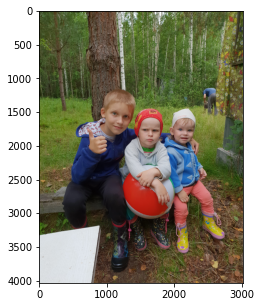

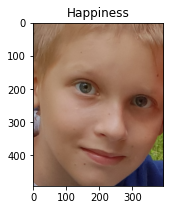

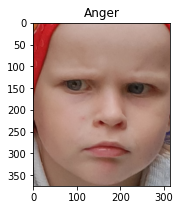

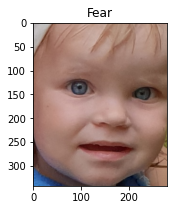

In [23]:
import matplotlib.pyplot as plt
fpath='../test_images/20180720_174416.jpg'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
bounding_boxes, points = imgProcessing.detect_faces(frame)
points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    img_tensor = test_transforms(Image.fromarray(face_img))
    img_tensor.unsqueeze_(0)
    scores = model(img_tensor.to(device))
    scores=scores[0].data.cpu().numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(face_img)
    plt.title(idx_to_class[np.argmax(scores)])

In [ ]:
imgProcessing.close()

### Feature extractor 

In [29]:
feature_extractor_model = torch.load(PATH)
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

# AFEW

In [27]:
DATA_DIR=os.path.join(ALL_DATA_DIR,'EmotiW/AFEW/')
print(DATA_DIR)
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}

/home/HDD6TB/datasets/emotions/EmotiW/AFEW/


In [30]:
def get_features(data_dir):
    filename2features={}
    for filename in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,filename)
        X_global_features,X_isface=[],[]
        imgs=[]
        for img_name in os.listdir(frames_dir):
            img = Image.open(os.path.join(frames_dir,img_name))
            img_tensor = test_transforms(img)
            X_isface.append('noface' not in img_name)
                
            if img.size:
                imgs.append(img_tensor)
                if len(imgs)>=16:        
                    #global_features,feats,scores=feature_extractor_model.predict(inp)
                    scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                    scores=scores.data.cpu().numpy()
                    #print(scores.shape)
            
                    #print(global_features.shape,feats.shape,scores.shape)
                    if len(X_global_features)==0:
                        X_global_features=scores
                    else:
                        X_global_features=np.concatenate((X_global_features,scores),axis=0)
                    
                    imgs=[]

        if len(imgs)>0:        
            scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
            scores=scores.data.cpu().numpy()
            #print(scores.shape)

            #print(global_features.shape,feats.shape,scores.shape)
            if len(X_global_features)==0:
                X_global_features=scores
            else:
                X_global_features=np.concatenate((X_global_features,scores),axis=0)

        X_isface=np.array(X_isface)
        #print(X_global_features.shape,X_feats.shape,X_scores.shape)
        filename2features[filename]=(X_global_features,X_isface)
    return filename2features

filename2features_val=get_features(os.path.join(DATA_DIR,'val/AlignedFaces_LBPTOP_Points_Val/frames_mtcnn_cropped/'))
filename2features_train=get_features(os.path.join(DATA_DIR,'train/AlignedFaces_LBPTOP_Points/frames_mtcnn_cropped/')) #_cropped

  0%|          | 0/383 [00:00<?, ?it/s]

  0%|          | 0/773 [00:00<?, ?it/s]

In [268]:
import pickle
MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw.pickle' #'_feat_bgr_emotiw.pickle'

#MODEL2EMOTIW_FEATURES='enet0_vggface2_new1_pt_feat_emotiw.pickle'
#MODEL2EMOTIW_FEATURES='enet0_vggface2_pt_feat_emotiw.pickle'
print(MODEL2EMOTIW_FEATURES)

enet0_vggface2_pt_feat_emotiw.pickle


In [49]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [269]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))

773 383


In [38]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for category in emotion_to_index:
        for filename in os.listdir(os.path.join(data_dir,category)):
            fn=os.path.splitext(filename)[0]
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            if True:
                #prev=features[0].shape
                cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[category])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(filename2features_train,os.path.join(DATA_DIR,'train'))
x_test, y_test, has_faces_test = create_dataset(filename2features_val,os.path.join(DATA_DIR,'val'))

(773, 5120) (773,)
(383, 5120) (383,)


In [39]:
x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')

In [42]:
clf = svm.LinearSVC(C=1.1) #0.5 1.1
#clf = svm.SVC(kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5989445910290238
Complete accuracy: 0.5926892950391645


# VGAF

In [43]:
DATA_DIR='/home/HDD6TB/datasets/emotions/EmotiW/VGAF/'
print(DATA_DIR)
emotion_to_index = {'Positive':1, 'Neutral':2, 'Negative':3}

/home/HDD6TB/datasets/emotions/EmotiW/VGAF/


In [71]:
def get_features_scores(data_dir):
    videoname2features={}
    for videoname in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,videoname)
        X_global_features=[]
        for filename in sorted(os.listdir(frames_dir)):
            faces_dir=os.path.join(frames_dir,filename)
            imgs=[]
            for img_name in sorted(os.listdir(faces_dir)):
                img = Image.open(os.path.join(faces_dir,img_name))
                img_tensor = test_transforms(img)
                
                if img.size:
                    imgs.append(img_tensor)

            if len(imgs)>0:        
                global_features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                global_features=global_features.data.cpu().numpy()
                #print(videoname,filename,global_features.shape)
                X_global_features.append(global_features)
        
        #print(videoname,len(X_global_features))
        videoname2features[videoname]=X_global_features
    return videoname2features

video2Allfeatures_val=get_features_scores(os.path.join(DATA_DIR,'preprocessed/Val/mtcnn_aligned'))
video2Allfeatures_train=get_features_scores(os.path.join(DATA_DIR,'preprocessed/Train/mtcnn_aligned'))

  0%|          | 0/766 [00:00<?, ?it/s]

  0%|          | 0/2661 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [46]:
#model_name='mobilenet_v1_ft'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_vgaf.pickle' #'_feat_bgr_emotiw.pickle'
MODEL2EMOTIW_FEATURES=model_name+'_feat_vgaf_aligned.pickle'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw_cropped.pickle'

#MODEL2EMOTIW_FEATURES='enet0_vggface2_new1_pt_feat_vgaf_aligned.pickle'
#MODEL2EMOTIW_FEATURES='enet0_vggface2_pt_feat_vgaf_aligned.pickle'
print(MODEL2EMOTIW_FEATURES)

enet0_8_pt_feat_vgaf_aligned.pickle


In [109]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([video2Allfeatures_train,video2Allfeatures_val], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    video2Allfeatures_train,video2Allfeatures_val=pickle.load(handle)
print(len(video2Allfeatures_train),len(video2Allfeatures_val))

2661 766


In [48]:
import csv
def create_dataset(videoname2features,labelsfile):
    x = []
    y = []
    has_faces=[]
    ind=0
    with open(labelsfile, mode='r') as csvfile:
        labels_reader = csv.reader(csvfile, delimiter=' ')
        for i,row in enumerate(labels_reader):
            if i==0:
                #print('first:',row)
                continue
            videoname,label=row[0],int(row[1])
            X_global_features=videoname2features[videoname]
            #print(videoname,label,len(X_global_features))
            
            total_features=[]
            for cur_features in X_global_features:
                #print(cur_features.shape)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                #feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                feature = np.concatenate((mean_features,std_features), axis=None)
                #feature=max_features
                
                total_features.append(feature)
            
            if len(total_features)>0:
                total_features=np.array(total_features)
                mean_features = (np.mean(total_features, axis=0))
                std_features = (np.std(total_features, axis=0))
                max_features = (np.max(total_features, axis=0))
                min_features = (np.min(total_features, axis=0))

                # join several features together
                #feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                feature = np.concatenate((mean_features,std_features), axis=None)
                #feature=max_features
                x.append(feature)
                has_faces.append(1)
            else:
                x.append(np.zeros_like(feature))
                has_faces.append(0)
            y.append(label-1)
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(video2Allfeatures_train,os.path.join(DATA_DIR,'Train_labels.txt'))
x_test, y_test, has_faces_test = create_dataset(video2Allfeatures_val,os.path.join(DATA_DIR,'Val_labels.txt'))

(2661, 5120) (2661,)
(766, 5120) (766,)


In [49]:
x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')

In [51]:
clf = svm.LinearSVC(C=0.5) #0.25
#clf = svm.SVC(kernel='rbf',C=1)
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6828609986504723
Complete accuracy: 0.6697127937336814
